In [2]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.quantum_info import state_fidelity, Statevector

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_textbook.tools import vector2latex
%matplotlib inline

In [3]:
def normalize(v):
    return v / np.linalg.norm(v)

In [4]:
def calc_z(a, b):
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)
    return a_mag**2 + b_mag**2

In [5]:
def psi_amp(a, b):
    
    a_norm = normalize(a)
    b_norm = normalize(b)
    
    return np.hstack([a_norm, b_norm]) * (1/np.sqrt(2))    

In [6]:
def phi_amp(a, b):
    
    z = calc_z(a, b)
    a_mag =  np.linalg.norm(a)
    b_mag =  np.linalg.norm(b)
    
    return np.hstack([a_mag, -b_mag])/np.sqrt(z)

In [7]:
def psi_circuit(a, b):

    amp = psi_amp(a, b) # 4 amplitudes 1/sqrt(2) (a0, a1, b0, b1)
    sz = 2
    
    qc = QuantumCircuit(sz) # 2 qubits if a,b in R^2

    qc.initialize(amp, [0,1])
    
    return qc

In [8]:
def phi_circuit(a, b):
    
    amp = phi_amp(a, b) # 4 amplitudes 1/sqrt(2) (a0, a1, b0, b1)
    sz = 1
    
    qc = QuantumCircuit(sz) # 2 qubits if a,b in R^2

    qc.initialize(amp, [0])
    
    return qc

In [9]:
def dot_product_circuit(a, b, state=False):
    
    qc = QuantumCircuit(1+2+1, 1) # ancilla + psi + phi

    psi = psi_circuit(a, b)
    qc.append(psi, [1,2])
    phi = phi_circuit(a, b)
    qc.append(phi, [3])
    
    qc.barrier()
    
    qc.h(0)
    qc.cswap(0, 2, 3) # perform test on v1 ancilla alone
    qc.h(0)
    
    if state == False:
        qc.measure(0,0)
    
    return qc

In [10]:
def run_circuit(qc):
    simulator = Aer.get_backend('qasm_simulator')
    return execute(qc, backend=simulator, shots=1000).result().get_counts(qc)

In [66]:
def calc_overlap(answer, state='0'):
    shots = answer[state] if len(answer) == 1 else answer['0']+answer['1']
    #return 1 - np.abs(counts[state]/1000 - 0.5)*2
    return np.abs(counts[state]/1000 - 0.5)*2

In [67]:
def calc_dist(answer, z, state='0'):
    return calc_overlap(answer, state)*2*z

In [12]:
psi_amp([1,1],[1,-1])

array([ 0.5,  0.5,  0.5, -0.5])

In [13]:
v = [0.3,0.9]
w = [0.1,1.2]

qc = psi_circuit(v, w)
state_vec = Statevector.from_instruction(qc).data

vector2latex(state_vec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

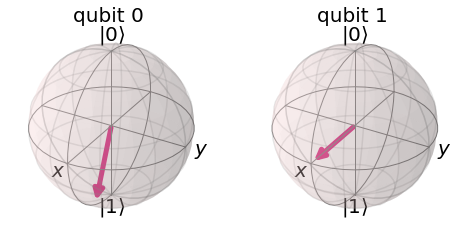

In [14]:
plot_bloch_multivector(state_vec)

In [15]:
qc = dot_product_circuit(v, w, state=True)

In [16]:
state_vec = Statevector.from_instruction(qc).data
vector2latex(state_vec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

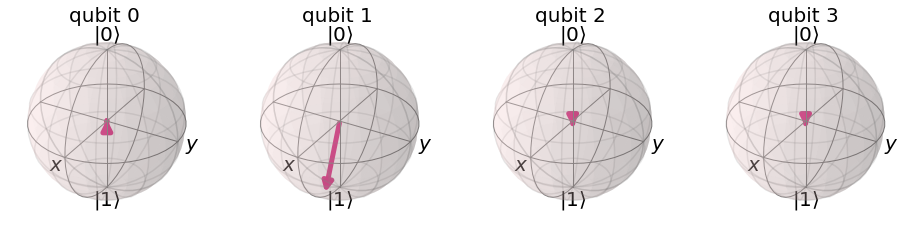

In [17]:
plot_bloch_multivector(state_vec)

In [18]:
qc.draw()

░ ┌───┐   ┌───┐
q_0: ────────────────░─┤ H ├─■─┤ H ├
     ┌─────────────┐ ░ └───┘ │ └───┘
q_1: ┤0            ├─░───────┼──────
     │  circuit-25 │ ░       │      
q_2: ┤1            ├─░───────X──────
     └┬────────────┤ ░       │      
q_3: ─┤ circuit-28 ├─░───────X──────
      └────────────┘ ░              
c: 1/═══════════════════════════════

In [19]:
v = [0.3,0.9]
w = [0.1,1.2]
qc = dot_product_circuit(v, w)

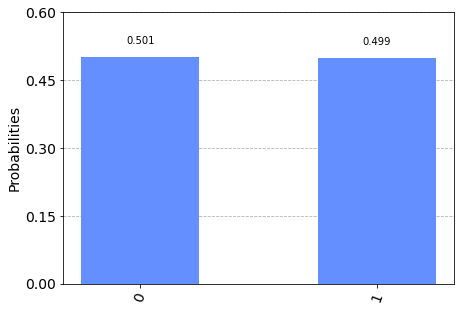

In [20]:
counts = run_circuit(qc)
plot_histogram(counts)

In [21]:
calculate_overlap(counts)

0.998

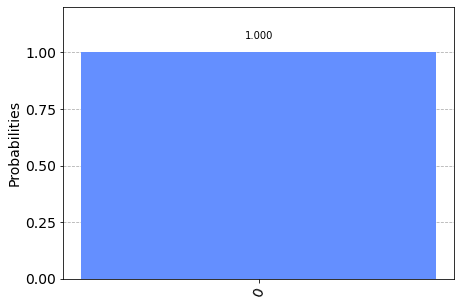

In [22]:
v = [0.3,0.9]
w = [-0.3,-1.0]
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [23]:
calculate_overlap(counts)

0.0

In [24]:
np.dot(v,w)

-0.99

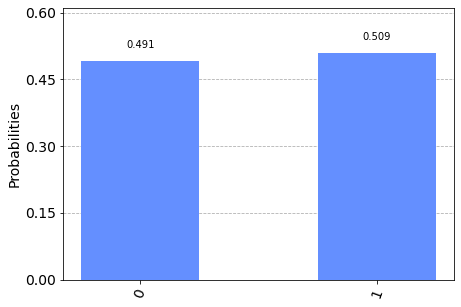

In [25]:
v = [0.3,0.9]
w = [0.3,0.9]
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [26]:
calculate_overlap(counts)

0.982

In [27]:
np.dot(v,w)

0.9

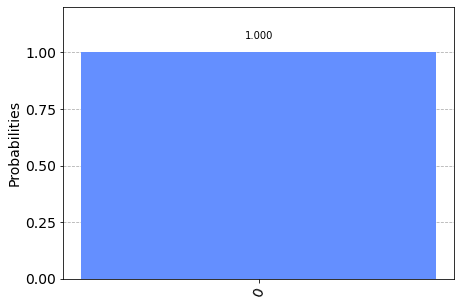

In [28]:
v = np.array([0.3,0.9])
w = np.array([-0.3,-0.9])
qc = dot_product_circuit(v, w)
counts = run_circuit(qc)
plot_histogram(counts)

In [29]:
calculate_overlap(counts)

0.0

In [30]:
np.linalg.norm(v-w)

1.8973665961010275

In [31]:
np.dot(v,w)

-0.9

## < a | a >

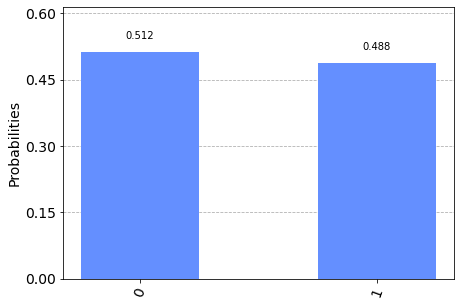

In [74]:
v = np.array([1,1])
qc = dot_product_circuit(v, v)
counts = run_circuit(qc)
plot_histogram(counts)

In [75]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,v)))
print('eucl dist: ', np.linalg.norm(v-v))

overlap:  0.02400000000000002
q-dist:  0.19200000000000023
eucl dist:  0.0


## < a | -a >

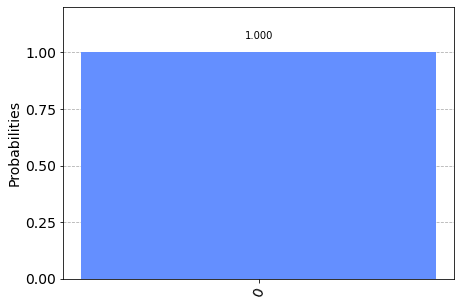

In [80]:
qc = dot_product_circuit(v, -v)
counts = run_circuit(qc)
plot_histogram(counts)

In [81]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,-v)))
print('eucl dist: ', np.linalg.norm(v+v))

overlap:  1.0
q-dist:  8.000000000000002
eucl dist:  2.8284271247461903


## < a | -2 a >

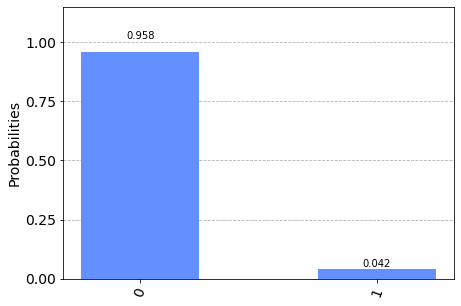

In [83]:
qc = dot_product_circuit(v, -2*v)
counts = run_circuit(qc)
plot_histogram(counts)

In [84]:
print('overlap: ', calc_overlap(counts))
print('q-dist: ', calc_dist(counts, calc_z(v,-2*v)))
print('eucl dist: ', np.linalg.norm(v+2*v))

overlap:  0.9159999999999999
q-dist:  18.32
eucl dist:  4.242640687119285


In [95]:
# calculate overlaps for different input vectors
dists_q = []
dists_eucl = []
overlaps = []
vectors = []
min_val = -2
max_val = 2
v = np.random.uniform(low=min_val, high=max_val, size=2)
for i in range(100):
        w = np.random.uniform(low=min_val, high=max_val, size=2)
        qc = dot_product_circuit(v, w)
        counts = run_circuit(qc)
        overlaps.append(calc_overlap(counts))
        dists_q.append(calc_dist(counts, calc_z(v, w)))
        dists_eucl.append(np.linalg.norm(v-w))
        vectors.append((v,w))

Text(0, 0.5, 'quantum distance')

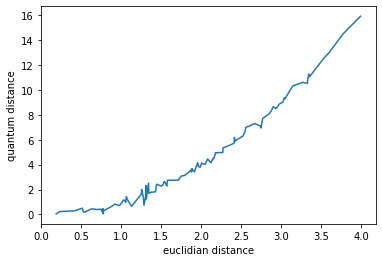

In [96]:
# plot results
d_eucl_srtd, d_q_srtd, overlaps_srtd, vectors_srtd = zip(*sorted(zip(dists_eucl, dists_q, overlaps, vectors)))
plt.plot(d_eucl_srtd, d_q_srtd)
plt.xlabel('euclidian distance')
plt.ylabel('quantum distance')